# Sentiment Analysis

## 03. Bidirectional LSTM & GRU with Attention

In this notebook are the two best bidirectional stacked LSTM and GRU networks with Attention.

### Libraries & Dataset

To pack the sequences easily I'll be using the legacy version of torchtext which provides some functionality that has been removed from later versions. So you first need to install the specific version below. (It might conflict with some packages, but I won't be using these.)

In [2]:
!pip install -U torchtext==0.9.0

#### Libraries

In [3]:
# Math, String, etc
import sys
import re
import os
import string
import time
import datetime
import random
import math

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import torchtext

# Numpy, Plotting, Metrics
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn

# Testing and metrics
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#### Functions for training & evaluation

In [19]:
# Function to train for one epoch
def trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display=True, clip_value = 0.6):

    losses = []

    # For each batch
    for batch, data in enumerate(dataloader):

        x, x_lengths = data.review
        y = data.rating
        
        # Predict and calculate loss
        prediction = neuralnetwork(x, x_lengths)
        loss = lossfunc(prediction, y)
        losses.append(loss.item())

        # Inform the weights
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradients
        nn.utils.clip_grad_norm_(neuralnetwork.parameters(), clip_value)
        optimizer.step()
        
        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = loss.item(), batch * len(x_lengths)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    meanloss = 0
    if len(losses)!=0:
        # The total mean loss
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a network
def trainNetwork(epochs, optimizer, dataloader, lossfunc, neuralnetwork, device, display=True, clip_value = 0.6):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display, clip_value)
        if (display):
            print("_________________________________")
        
    # Returns the neural network
    return neuralnetwork

# Evaluation function
def evaluationFunction(dataloader, model, lossfunc, device, display=True):

    # Variable initialisation
    correctCount = 0
    sampleCount = 0
    losses = []
    preds = []
    trues = []
    probs = []

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():
        
        for batch, data in enumerate(dataloader):
            
            x, x_lengths = data.review
            y = data.rating

            # Make predictions
            scores = model(x, x_lengths)
            _, predictions = scores.max(1)

            # Probability estimates of the positive class
            y_probs = torch.sigmoid(scores[:,1]).cpu()
            
            # Loss
            loss = lossfunc(scores, y).item()
            losses.append(loss)

            # Saving them for the metrics later
            predictions= torch.abs(predictions.cpu())
            y=y.cpu()
            probs.extend(y_probs.numpy())
            preds.extend(predictions.numpy())
            trues.extend(y.numpy())
            correctCount += (predictions==y).sum()
            sampleCount += predictions.size(0)

    # Metric calculations
    f1macro = f1_score(torch.tensor(trues),torch.tensor(preds), average="macro").item() * 100
    accuracy = float(correctCount) / float(sampleCount) * 100
    meanloss = sum(losses)/len(losses)
    recall = recall_score(y_true=trues, y_pred=preds) * 100
    precision = precision_score(y_true=trues, y_pred=preds) * 100

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correctCount} / {sampleCount} correctly"
            f"\nMean Loss: {meanloss:.2f} "
            f"\nRecall: {recall:.2f}%"
            f"\nPrecision: {precision:.2f}%"
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1macro:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return trues, preds, probs ,meanloss, accuracy, f1macro, recall, precision

# Confusion Matrix plotting
def confusionMatrix(trues, preds):
    names =["negative", "positive"]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 2, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    seaborn.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

# Roc Curve plotting and also returns roc auc score
def rocCurve(trues, preds, probs):
    false_positive_rate, true_positive_rate, threshold = roc_curve(trues, probs)
    roc_auc = roc_auc_score(trues, preds)
    plt.style.use('seaborn')
    plt.subplots(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label="AUC="+str(roc_auc))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7") 
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

def seedTorch(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# Training till loss stops improving for patience
def earlyStop(device, model, display, epochs, traindataloader, valdataloader, lr, opti, lossfunc, patience, clip_value = 0.6):

    stopepoch=0
    countStop=0
    bestMeanloss= sys.float_info.max
    optimizer = opti(model.parameters(), lr = lr , weight_decay=1e-6)
    scheduler=lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.4, patience=1, verbose=False)

    # For each epoch
    for epoch in range(epochs):

        # If iterations are equal to patience
        if countStop==patience:
            print("Early stopping on epoch: ", epoch)
            stopepoch=epoch
            break

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display, clip_value = 0.6)
        _, _, _, meanlossval, accura, macrof1, recall, precision =  evaluationFunction(valdataloader, model, lossfunc, device, display)

        # If mean loss is less than the best so far
        if bestMeanloss>meanlossval:
            countStop=0
            bestMeanloss=meanlossval
        else:
            countStop+=1
        
        scheduler.step(meanLoss)    

    return model, stopepoch

# Function automating finding best model
def optimalModel(device, model, epochs, traindataloader, valdataloader, optimizer, lossfunc, display=False,clip_value = 0.6):

    # Variable initialisation
    bestf1=0
    bestepoch=0
    trainlosses = []
    validlosses = []
    average = 0
    
    # Adding the scheduler
    scheduler=lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.4, patience=1, verbose=False)
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Train the model
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display, clip_value)

        # Evaluation
        _, _, _, meanlossval, accura, macrof1, recall, precision = evaluationFunction(valdataloader, model, lossfunc, device, display)

        if (display):
            print("Training loss: ", meanLoss , " validation loss: ", meanlossval, " and accuracy: ", accura)
    
        trainlosses.append(meanLoss)
        validlosses.append(meanlossval)
        average += abs(meanLoss-meanlossval)
        
        # If f1 score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './bestModel.pt')
            torch.save(optimizer.state_dict(), './bestOptimizer.pt')
            
        scheduler.step(meanLoss)
    
        if(display):
            print("__________________________________")

    print("Training loss - validation loss average difference: ", abs(average/len(trainlosses)))

    x = list(range(0, len(trainlosses)))
    plt.style.use('seaborn')
    plt.plot(x, trainlosses, linestyle="-", label="Training")
    plt.plot(x, validlosses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    return bestepoch
    
DEVICE='cuda'
torch.cuda.is_available()

True

The data ingestion as the previous notebooks.

In [5]:
df = pd.read_csv("/kaggle/input/imdbreviews/imdb-reviews.csv", sep = '\t')
df.columns = ['url', 'rating', 'review']
X = df['review']
Y = df[['rating']].copy()

# classify the ratings as positive and negative
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

frames = [X, Y]
conc = pd.concat(frames, axis=1)
conc.to_csv('proper_data.csv', index=None)
df = pd.read_csv('/kaggle/input/properdata/proper_data.csv')
df.head()

,review,rating
0,I thought this was a quiet good movie. It was ...,1.0
1,Wagon Master is a very unique film amongst Joh...,1.0
2,This film has to be as near to perfect a film ...,1.0
3,I gave this 4 stars because it has a lot of in...,0.0
4,This movie is really genuine and random. It's ...,1.0


In [6]:
# Field and Label Field for review and sentiment
REVIEW = torchtext.legacy.data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm', include_lengths=True)
SENTIMENT = torchtext.legacy.data.LabelField(dtype=torch.long)
fields = [('review', REVIEW), ('rating', SENTIMENT)]
dataset = torchtext.legacy.data.TabularDataset(path='/kaggle/input/properdata/proper_data.csv', format='csv', skip_header=True, fields=fields)
train_dataset, test_dataset = dataset.split(split_ratio=[0.8, 0.2])
train_dataset, val_dataset = train_dataset.split(split_ratio=[0.85, 0.15])

### Build vocabulary and dataloaders using 35k vocabulary

In [7]:
DEVICE = 'cuda'
VOCAB_SIZE = 35000
BATCH_SIZE = 32
REVIEW.build_vocab(train_dataset, max_size=VOCAB_SIZE, vectors='glove.6B.100d', unk_init=torch.Tensor.normal_)
SENTIMENT.build_vocab(train_dataset)
train_dataloader, val_dataloader, test_dataloader = torchtext.legacy.data.BucketIterator.splits((train_dataset, val_dataset, test_dataset), batch_size=BATCH_SIZE, sort_within_batch=True, sort_key=lambda x: len(x.review), device=DEVICE)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                               
100%|█████████▉| 399999/400000 [00:16<00:00, 24375.87it/s]


#### Initial Test
The best GRU model that has been found is below. It is a bidirectional stacked RNN that uses multiheaded attention.

In [8]:
class GRU_05(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.gru = torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, h_0 = self.gru(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        h_0 = self.dropout(h_0)
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(h_0), dim=1)
            attention_output = h_0 * attention
            attention_outputs.append(attention_output)
        h_0 = torch.cat(attention_outputs, dim=1)
        output = self.linear(h_0)
        return output

Training the netowrk for 3 epochs and early stopping.

Best F1 score after  0  epochs.
Training Time: 1.96 minutes

Evaluation Results
_________________________________
Predicted 8191 / 9002 correctly
Mean Loss: 0.36 
Recall: 92.08%
Precision: 90.09%
Accuracy: 90.99%
Macro Averaged F1-score: 90.99%
_________________________________


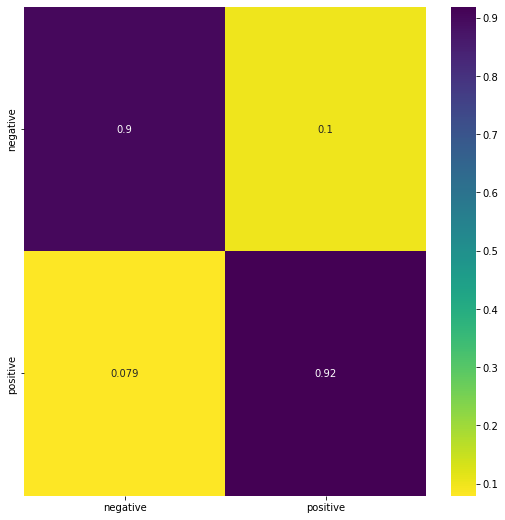

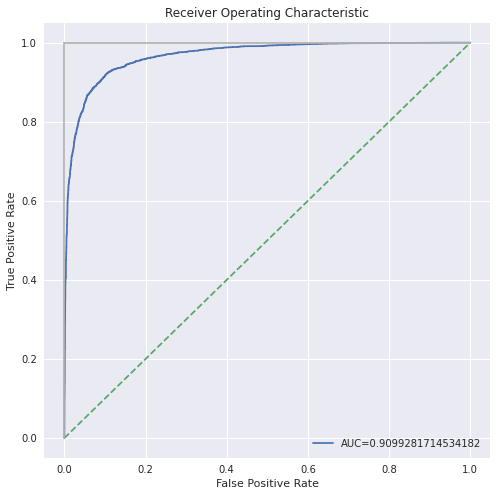

In [9]:
LR = 0.0045
EPOCHS = 3
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
CLIP_VALUE = 0.7
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

### LSTM Best Model

Then similarly for the best bidirectional LSTM.

In [14]:
class LSTM_01(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.lstm = torch.nn.LSTM(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, (h_0, _) = self.lstm(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        h_0 = self.dropout(h_0)
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(h_0), dim=1)
            attention_output = h_0 * attention
            attention_outputs.append(attention_output)
        
        h_0 = torch.cat(attention_outputs, dim=1)
        
        output = self.linear(h_0)
        return output

Training the LSTM with it's optimal parameters.

Best F1 score after  0  epochs.
Training Time: 4.03 minutes

Evaluation Results
_________________________________
Predicted 8173 / 9002 correctly
Mean Loss: 0.25 
Recall: 90.12%
Precision: 91.32%
Accuracy: 90.79%
Macro Averaged F1-score: 90.79%
_________________________________


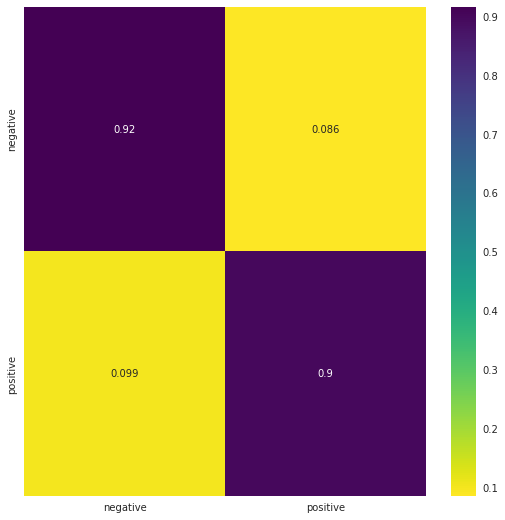

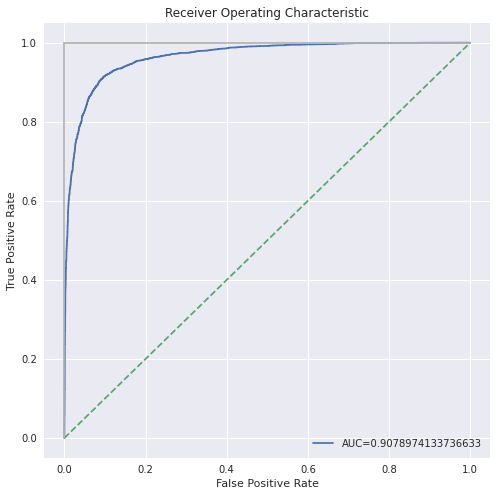

In [16]:
EPOCHS = 3
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 4
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LR = 0.005
HIDDEN = 64
CLIP_VALUE = 0.9

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

## Saving the Optimal Model

I will train only for 3 epochs again, also I'll be using the weight decay I've been using in the early stopping function which I tested locally and works well and the the ReduceLROnPlateau scheduler.

Epoch 1
__________________________________
loss: 0.692360  [    0/30605]
loss: 0.673087  [ 2048/30605]
loss: 0.679314  [ 4096/30605]
loss: 0.680750  [ 6144/30605]
loss: 0.588224  [ 8192/30605]
loss: 0.644694  [10240/30605]
loss: 0.608183  [12288/30605]
loss: 0.524515  [14336/30605]
loss: 0.385441  [16384/30605]
loss: 0.390525  [18432/30605]
loss: 0.328068  [20480/30605]
loss: 0.316380  [22528/30605]
loss: 0.321931  [24576/30605]
loss: 0.475821  [26624/30605]
loss: 0.441282  [28672/30605]

Evaluation Results
_________________________________
Predicted 4773 / 5401 correctly
Mean Loss: 0.29 
Recall: 83.81%
Precision: 92.27%
Accuracy: 88.37%
Macro Averaged F1-score: 88.35%
_________________________________
Training loss:  0.5136844464728576  validation loss:  0.2871987443615699  and accuracy:  88.37252360673949
__________________________________
Epoch 2
__________________________________
loss: 0.203955  [    0/30605]
loss: 0.230220  [ 2048/30605]
loss: 0.118239  [ 4096/30605]
loss: 0.12457

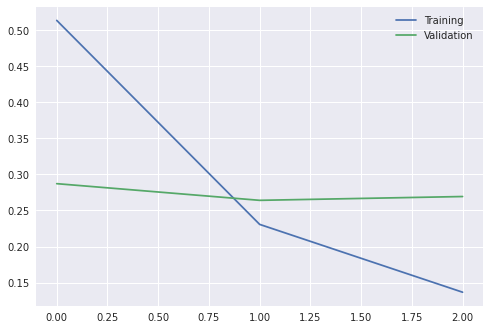

Best F1 score after  0  epochs.
Training Time: 4.01 minutes

Evaluation Results
_________________________________
Predicted 8094 / 9002 correctly
Mean Loss: 0.26 
Recall: 87.42%
Precision: 91.97%
Accuracy: 89.91%
Macro Averaged F1-score: 89.91%
_________________________________


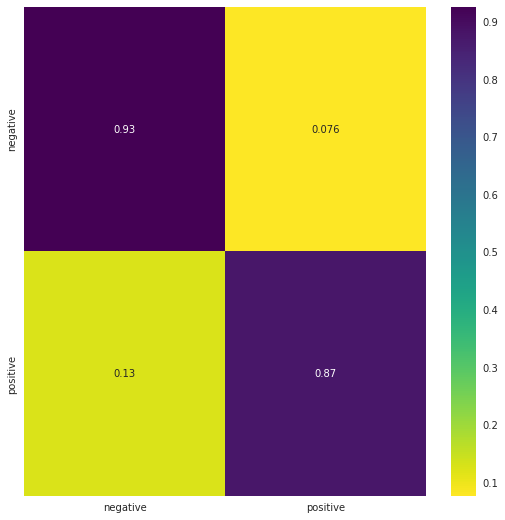

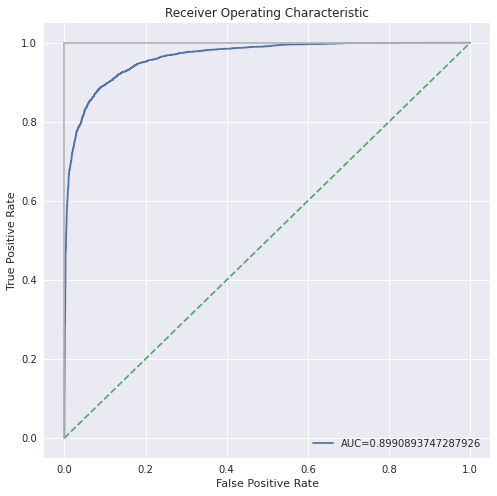

In [21]:
EPOCHS = 3
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 4
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LR = 0.005
HIDDEN = 64
CLIP_VALUE = 0.9

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Finally the best GRU.

Epoch 1
__________________________________
loss: 0.693891  [    0/30605]
loss: 0.801726  [ 2048/30605]
loss: 0.686324  [ 4096/30605]
loss: 0.615801  [ 6144/30605]
loss: 0.526138  [ 8192/30605]
loss: 0.342921  [10240/30605]
loss: 0.614457  [12288/30605]
loss: 0.348988  [14336/30605]
loss: 0.323775  [16384/30605]
loss: 0.327606  [18432/30605]
loss: 0.265226  [20480/30605]
loss: 0.234797  [22528/30605]
loss: 0.140363  [24576/30605]
loss: 0.253400  [26624/30605]
loss: 0.241843  [28672/30605]

Evaluation Results
_________________________________
Predicted 4875 / 5401 correctly
Mean Loss: 0.25 
Recall: 94.75%
Precision: 86.97%
Accuracy: 90.26%
Macro Averaged F1-score: 90.24%
_________________________________
Training loss:  0.3988226238607021  validation loss:  0.252048596585467  and accuracy:  90.26106276615442
__________________________________
Epoch 2
__________________________________
loss: 0.101135  [    0/30605]
loss: 0.110827  [ 2048/30605]
loss: 0.143635  [ 4096/30605]
loss: 0.261999

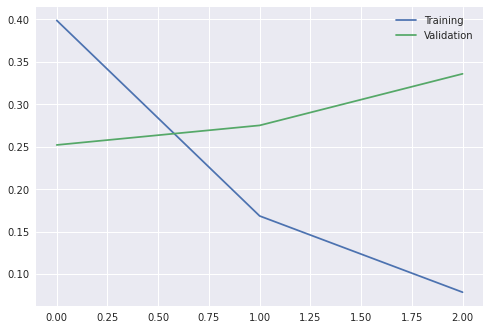

Best F1 score after  0  epochs.
Training Time: 1.96 minutes

Evaluation Results
_________________________________
Predicted 8143 / 9002 correctly
Mean Loss: 0.36 
Recall: 93.41%
Precision: 88.17%
Accuracy: 90.46%
Macro Averaged F1-score: 90.45%
_________________________________


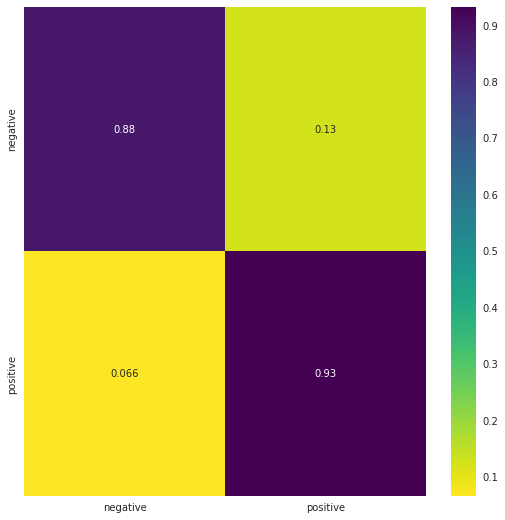

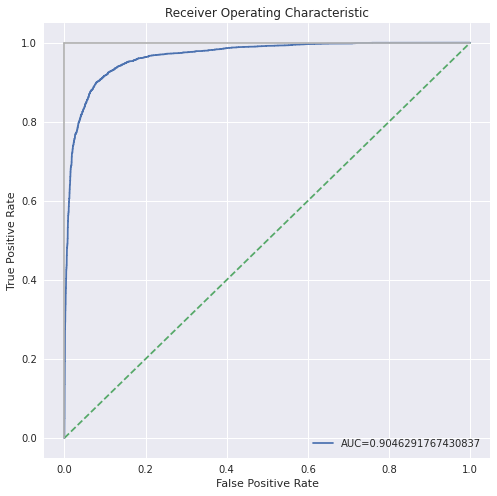

In [22]:
LR = 0.0045
EPOCHS = 3
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
CLIP_VALUE = 0.7
HEADS = 3
CLASSES = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The performance on the test set is excellent scoring over 90% accuracy and similarly across all metrics.